In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import numpy as np
import sys

In [2]:
mnist = tf.keras.datasets.fashion_mnist

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False

        valid = self.discriminator(img)

        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        (X_train, _), (_, _) = mnist.load_data()        
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            g_loss = self.combined.train_on_batch(noise, valid)

            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("mnist_%d.png" % epoch)
        plt.close()


gan = GAN()
gan.train(epochs=10000, batch_size=32, sample_interval=2500)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trai

1/1 [==============================] - 0s 51ms/step


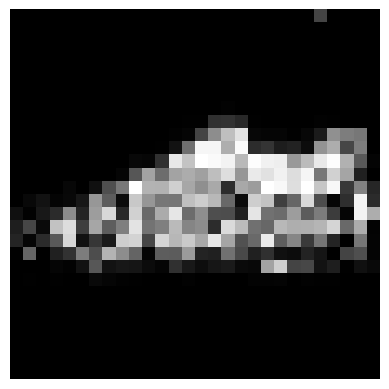

In [3]:
random_noise = np.random.normal(0, 1, (1, 100))
generated_image = gan.generator.predict(random_noise)
generated_image = 0.5 * generated_image + 0.5
import matplotlib.pyplot as plt
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()